## Set-up

### Load modules

In [1]:
import os # module for interacting with files and folders
from audio_processing import *
from audio_display import *
from array_manipulation import *
from load_audio import *
from feature_normalize import *
from pca_paths import *
from frame_clustering import *
from segments import *
from time_series import *
from bespoke_segmentation import *

### Load Audio Files

In [2]:
paths = [r'sound/American-English/Narrative',
        r'sound/American-English/Consonants',
        r'sound/American-English/Vowels',
        r'sound/Non-speech']

out_path = 'sound/out/'

fns,audio_data = load_audio(paths_list=paths, pad=0,nonspeech_dur=2)

narrative_fns,consonants_fns,vowels_fns,nonspeech_fns = fns
narrative_data,consonants_data,vowels_data,nonspeech_data = audio_data

### Normalization from Narrative Data

In [3]:
narr = get_narr(narrative_fns,pad=0)
narr_scaler = get_scaler(narrative_fns)

narr_frames = np.transpose(norm_array_hor(narr,narr_scaler))
print(narr_frames.shape)

narr_pca = PCA(n_components=3).fit(narr_frames)
narr_pcs = narr_pca.transform(narr_frames)
print(f'Explained variance ratio: \n{narr_pca.explained_variance_ratio_}')

(9549, 12)
Explained variance ratio: 
[0.27587196 0.17633568 0.15477869]


In [4]:
clip_dict = {}
path_test_fns = vowels_fns+consonants_fns+nonspeech_fns
for clip_fn in path_test_fns:
  name = clip_fn.split("/")[-1].split(".")[0].title()
  clip_data = process_audio(clip_fn,n_mfcc_list=[12],pad = 0)
  fourier = clip_data["fourier"]
  sr = clip_data["sr"]
  normed_mfcc = norm_array_hor(clip_data["mfcc"]["12"],narr_scaler)
  clip_frames = np.transpose(normed_mfcc)
  clip_pca = narr_pca.transform(clip_frames)
  clip_dict[name] = {"frames":clip_frames,"pca":clip_pca}

print(clip_dict.keys())
print(clip_dict["Bird"].keys())
print(clip_dict["Bird"]['frames'].shape)
print(clip_dict["Bird"]['pca'].shape)

dict_keys(['Bird', 'Bed', 'Bid', 'Above', 'Bayed', 'Good', 'Buy', 'Bud', 'Bead', 'Bough', 'Bad', 'Boy', 'Booed', 'Bode', 'Pod', 'Sigh', 'Shy', 'Fie', 'Rye', 'Die', 'Why', 'Hang', 'Guy', 'Thigh', 'You', 'Thy', 'Gin', 'Vie', 'My', 'Azure', 'Tie', 'High', 'Pie', 'Kite', 'Chin', 'Lie', 'Nigh', 'Zoo', 'Train', 'Water'])
dict_keys(['frames', 'pca'])
(202, 12)
(202, 3)


### Generate Bouquets

#### Segmentation

Sample rate = 22050
Frame Width = 2.902 ms
Clip length = 27.716 s
Number of segments: 277


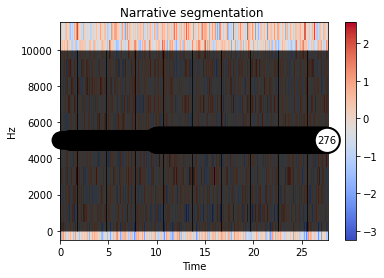

In [5]:
narr_len = len(narr_frames)

res = 3
sr = sr
hop = 2**(9-res)
w = hop/sr

sig_figs = 3

print(f"Sample rate = {sr}")
print(f"Frame Width = {round(1000*w,sig_figs)} ms")
print(f"Clip length = {round(w*narr_len,sig_figs)} s")
even_segmentation = get_even_segments(narr_len,frame_w=w,seg_ms=100,clip_last = False)
print(f"Number of segments: {len(even_segmentation)}")

plot_segments_on_mfcc(np.transpose(narr_frames),even_segmentation,sr,title=f"Narrative segmentation ",line_color='black',complete = False)

#### Bouquet


In [6]:
narr_bouquet_list = []
n_iter_list = [[2],[3],[4],[5],[2,3],[3,4],[4,5],[2,3,4],[3,4,5],[2,3,4,5]]
n_iter_list = [[1],[2],[3],[5],[2,3],[2,5]]
#n_iter_list = [[2,3]]
for n_iter in n_iter_list:
    narr_bouquet_list.append(get_bouquet(even_segmentation,n_iter=n_iter,text_method = 'count'))

for j,narr_bouquet in enumerate(narr_bouquet_list):
    print(f'Number of intervals in bouquet #{j+1} = {len(narr_bouquet_list[j])}')
    for i in [1,2,3,4,5]:
        print(f'Number of {i}-segment intervals = {len([s for s in narr_bouquet_list[j] if s["text"] == str(i)])}')

Number of intervals in bouquet #1 = 277
Number of 1-segment intervals = 277
Number of 2-segment intervals = 0
Number of 3-segment intervals = 0
Number of 4-segment intervals = 0
Number of 5-segment intervals = 0
Number of intervals in bouquet #2 = 276
Number of 1-segment intervals = 0
Number of 2-segment intervals = 276
Number of 3-segment intervals = 0
Number of 4-segment intervals = 0
Number of 5-segment intervals = 0
Number of intervals in bouquet #3 = 275
Number of 1-segment intervals = 0
Number of 2-segment intervals = 0
Number of 3-segment intervals = 275
Number of 4-segment intervals = 0
Number of 5-segment intervals = 0
Number of intervals in bouquet #4 = 273
Number of 1-segment intervals = 0
Number of 2-segment intervals = 0
Number of 3-segment intervals = 0
Number of 4-segment intervals = 0
Number of 5-segment intervals = 273
Number of intervals in bouquet #5 = 551
Number of 1-segment intervals = 0
Number of 2-segment intervals = 276
Number of 3-segment intervals = 275
Number

#### Split MFCC

In [123]:
narr_bouquet_mfcc_list = []
for narr_bouquet in narr_bouquet_list:
    narr_bouquet_mfcc_list.append(split_frames(narr_bouquet,narr_frames))
    print(len(narr_bouquet_mfcc_list[-1]))
    print(set([frames.shape[0] for frames in narr_bouquet_mfcc_list[-1]]))

277
{34, 35}
276
{68, 69}
275
{104, 103}
273
{172, 173}
551
{104, 68, 69, 103}
549
{172, 68, 69, 173}


In [8]:
fav_index = 4
narr_bouquet = narr_bouquet_list[fav_index]
narr_bouquet_mfcc = narr_bouquet_mfcc_list[fav_index]
n_iter = n_iter_list[fav_index]
print(n_iter)

data = [item for sublist in audio_data for item in sublist]

[2, 3]


## Splits

In [124]:
word = "Above"
word_frames = clip_dict[word]["frames"]

seg = get_even_segments(word_frames.shape[0],w,n_segments=1)

scores_list = []
best_splits_list = []
for narr_bouquet_mfcc in narr_bouquet_mfcc_list:
    scores_list.append(get_split_scores(word_frames,narr_bouquet_mfcc))
    best_splits_list.append(get_best_splits(np.array(scores_list[-1])))
    print(list(zip(best_splits_list[-1][0],[round(score,3) for score in best_splits_list[-1][1]])))


[(16, 0.486), (215, 0.953)]


KeyboardInterrupt: 

In [ ]:
for i,narr_bouquet_mfcc in enumerate(narr_bouquet_mfcc_list):
    print(f'{round(recurrence_score(word_frames,narr_bouquet_mfcc),3)}{list(zip(best_splits_list[i][0],[round(score,3) for score in best_splits_list[i][1]]))} ({(n_iter_list[i])})')

0.139[(18, 0.344), (52, 0.376), (69, 0.373), (162, 0.519), (213, 0.534)] ([2])
0.14[(52, 0.323), (63, 0.324), (161, 0.415), (185, 0.37), (212, 0.381)] ([3])
0.136[(52, 0.279), (63, 0.28), (69, 0.283), (161, 0.339), (185, 0.297), (212, 0.301)] ([4])
0.129[(52, 0.242), (63, 0.243), (69, 0.245), (161, 0.283), (185, 0.248), (212, 0.25)] ([5])
0.279[(52, 0.699), (63, 0.695), (69, 0.702), (162, 0.933), (213, 0.915)] ([2, 3])
0.276[(52, 0.603), (63, 0.604), (69, 0.612), (161, 0.754), (185, 0.666), (212, 0.682)] ([3, 4])
0.264[(52, 0.521), (63, 0.523), (69, 0.528), (161, 0.622), (185, 0.545), (212, 0.551)] ([4, 5])
0.415[(52, 0.979), (63, 0.976), (69, 0.985), (161, 1.272), (186, 1.164), (213, 1.216)] ([2, 3, 4])
0.404[(52, 0.845), (63, 0.847), (69, 0.857), (161, 1.037), (185, 0.915), (212, 0.932)] ([3, 4, 5])
0.543[(52, 1.221), (63, 1.218), (69, 1.23), (161, 1.555), (186, 1.413), (213, 1.466)] ([2, 3, 4, 5])


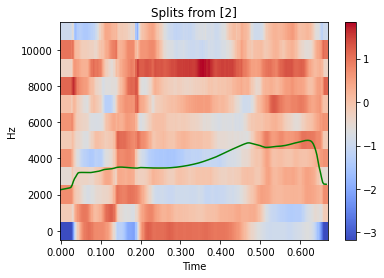

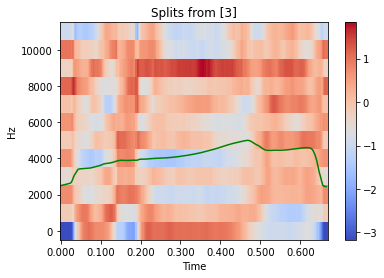

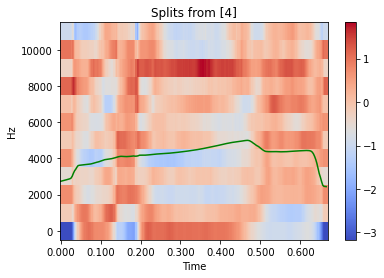

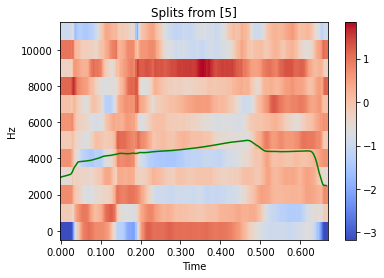

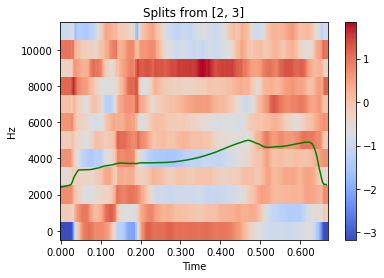

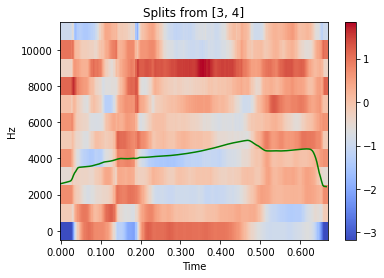

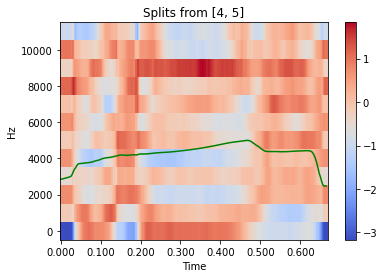

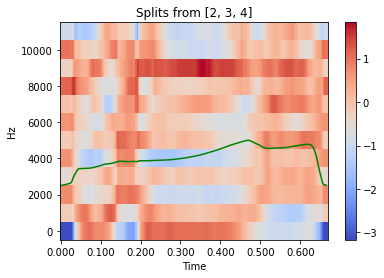

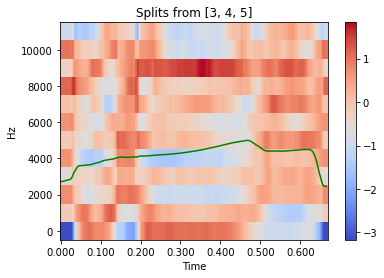

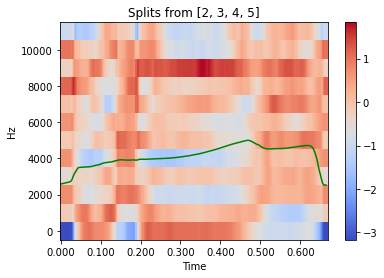

In [ ]:
for i,scores in enumerate(scores_list):
    plot_timeseries_on_mfcc(np.transpose(word_frames),scores,sr,title="Splits from "+str(n_iter_list[i]),line_color='green')

## Recurrence score temporal bias testing

In [125]:
def recurrence_square(mfcc,comp_frames_list,pixel=10):
  mfcc_len = mfcc.shape[0]
  triangle_list = []
  for w in range(0,mfcc_len,pixel):
    row_list = []
    for v in range(0,mfcc_len,pixel):
      if w<=v:
        d = 0
      else:
        interval = np.split(mfcc,[v,w])[1]
        #d = w-v
        d = recurrence_score(interval,comp_frames_list)
      row_list.append(d)
    #print(f'Row {w} complete')
    row = np.array(row_list)
    triangle_list.append(row)
  triangle = np.stack(triangle_list,axis=1)
  return triangle

In [150]:
my_square_list = []
word = "Water"
pixel = 5
clip_frames = np.transpose(norm_array_hor(nonspeech_data[1]["mfcc"]["12"],narr_scaler))
#clip_frames = clip_dict[word]["frames"]

print(f'Length: {round(clip_frames.shape[0]*w,3)}s')

for i,bouquet in enumerate(narr_bouquet_mfcc_list):
    my_square = recurrence_square(clip_frames,bouquet,pixel=pixel)
    my_square_list.append(my_square)
    print(f'{n_iter_list[i]} square for {word} complete')

Length: 2.003s
[1] square for Water complete
[2] square for Water complete
[3] square for Water complete
[5] square for Water complete
[2, 3] square for Water complete
[2, 5] square for Water complete


: 

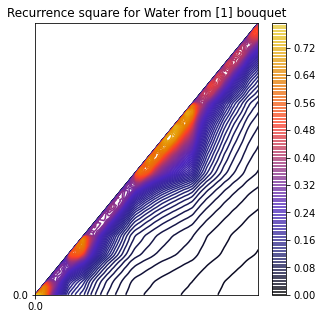

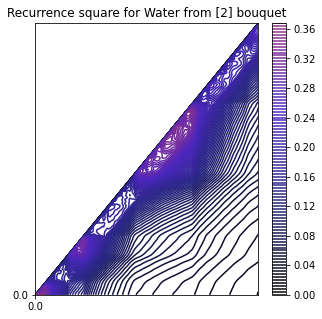

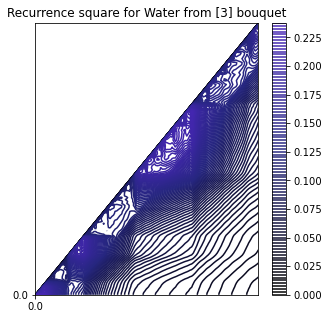

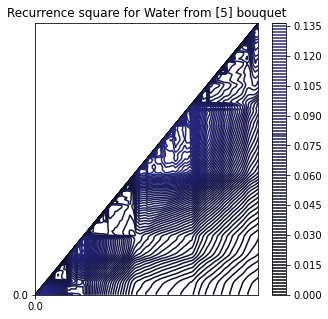

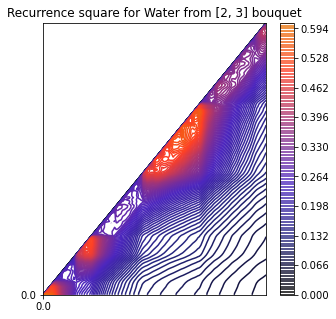

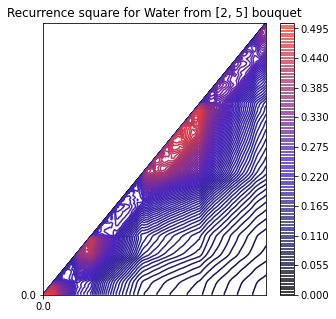

In [ ]:
dur = (1/pixel)*w*clip_frames.shape[0]*w
for i,my_square in enumerate(my_square_list):
    title = "Recurrence square for "+word+" from "+str(n_iter_list[i])+" bouquet"
    plot_sound_square(my_square,dur=dur,sr = sr,colors='CMRmap',size=5,heat_max=1,title=title)

## Refinement

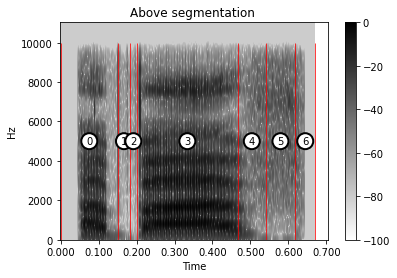

In [12]:
word = "Above"
word_frames = clip_dict[word]["frames"]

word_data = next(item for item in data if item["fn"].split("/")[-1].split(".")[0].title() == word)
seg = get_even_segments(word_frames.shape[0],w,n_segments=1,text_method='index')

refined_seg = recurrence_refine(seg,word_frames,narr_bouquet_mfcc,zeal=0.5,text_method='raw_index')
plot_segments_on_spectrogram(word_data["fourier"],refined_seg,sr,title=f"{word} segmentation ",line_color='red')

In [13]:
mylist = list(clip_dict.keys())
print(mylist)

['Bird', 'Bed', 'Bid', 'Above', 'Bayed', 'Good', 'Buy', 'Bud', 'Bead', 'Bough', 'Bad', 'Boy', 'Booed', 'Bode', 'Pod', 'Sigh', 'Shy', 'Fie', 'Rye', 'Die', 'Why', 'Hang', 'Guy', 'Thigh', 'You', 'Thy', 'Gin', 'Vie', 'My', 'Azure', 'Tie', 'High', 'Pie', 'Kite', 'Chin', 'Lie', 'Nigh', 'Zoo', 'Train', 'Water']


In [14]:
refined_seg_dict = {}
pruned_seg_dict = {}

Refined segmentation for Above complete (7 intervals)
Refined segmentation for Bird complete (5 intervals)
Refined segmentation for Buy complete (7 intervals)
Refined segmentation for Sigh complete (7 intervals)


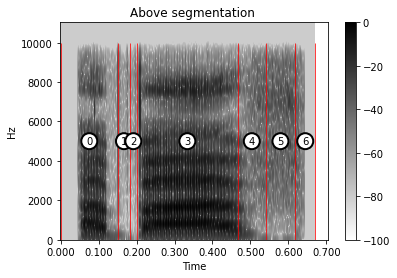

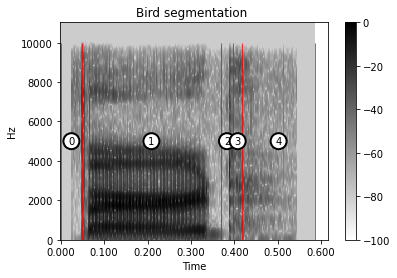

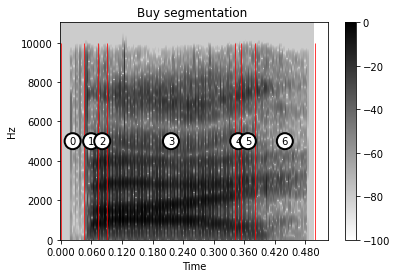

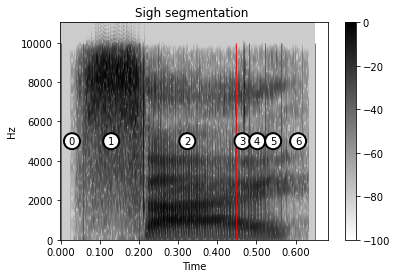

In [15]:
for word in ["Above","Bird","Buy","Sigh"]:
    word_frames = clip_dict[word]["frames"]
    word_data = next(item for item in data if item["fn"].split("/")[-1].split(".")[0].title() == word)
    
    seg = get_even_segments(word_frames.shape[0],w,n_segments=1)

    refined_seg = recurrence_refine(seg,word_frames,narr_bouquet_mfcc,zeal=0.5,text_method='raw_index')

    print(f'Refined segmentation for {word} complete ({len(refined_seg)} intervals)')
    refined_seg_dict[word] = refined_seg
    #plot_segments_on_mfcc(np.transpose(word_frames),new_seg,sr,title=f"{word} segmentation",line_color='black')
    plot_segments_on_spectrogram(word_data["fourier"],refined_seg,sr,title=f"{word} segmentation ",line_color='red')

## Pruning

Pruned segmentation for Above complete (5 intervals)


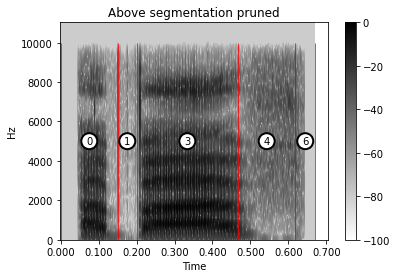

In [16]:
word = "Above"
word_frames = clip_dict[word]["frames"]
word_data = next(item for item in data if item["fn"].split("/")[-1].split(".")[0].title() == word)

pruned_seg = recurrence_prune(refined_seg_dict[word],word_frames,narr_bouquet_mfcc,text_method='first')
print(f'Pruned segmentation for {word} complete ({len(pruned_seg)} intervals)')

#plot_segments_on_mfcc(np.transpose(word_frames),pruned_seg,sr,title=f"{word} segmentation pruned",line_color='black')
plot_segments_on_spectrogram(word_data["fourier"],pruned_seg,sr,title=f"{word} segmentation pruned",line_color='red')

Pruned segmentation for Above complete (5 intervals)
Pruned segmentation for Bird complete (4 intervals)
Pruned segmentation for Buy complete (3 intervals)
Pruned segmentation for Sigh complete (5 intervals)


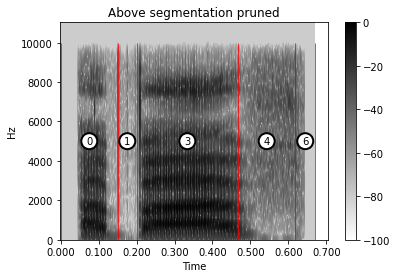

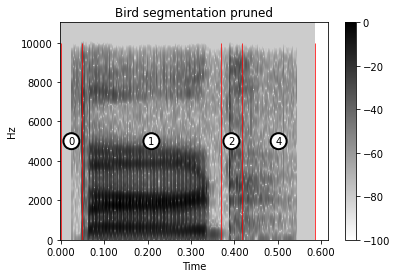

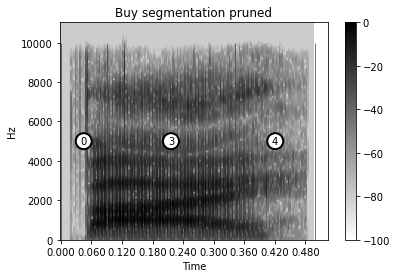

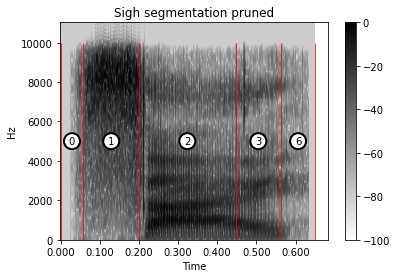

In [17]:
for word in ["Above","Bird","Buy","Sigh"]:
    word_frames = clip_dict[word]["frames"]
    word_data = next(item for item in data if item["fn"].split("/")[-1].split(".")[0].title() == word)

    pruned_seg = recurrence_prune(refined_seg_dict[word],word_frames,narr_bouquet_mfcc,text_method='first')
    pruned_seg_dict[word] = pruned_seg
    print(f'Pruned segmentation for {word} complete ({len(pruned_seg)} intervals)')

    #plot_segments_on_mfcc(np.transpose(word_frames),pruned_seg,sr,title=f"{word} segmentation pruned",line_color='black')
    plot_segments_on_spectrogram(word_data["fourier"],pruned_seg,sr,title=f"{word} segmentation pruned",line_color='red')

## Recursive

In [18]:
refined_seg_dict2 = {}
pruned_seg_dict2 = {}

In [19]:
data = [item for sublist in audio_data for item in sublist]

for word in ["Above","Bird","Buy","Sigh"]:
    word_frames = clip_dict[word]["frames"]

    word_data = next(item for item in data if item["fn"].split("/")[-1].split(".")[0].title() == word)
    seg = pruned_seg_dict[word]

    refined_seg = recurrence_refine(seg,word_frames,narr_bouquet_mfcc,zeal=0.5,text_method='index')

    print(f'Level 2 refined segmentation for {word} complete ({len(refined_seg)} intervals)')
    refined_seg_dict2[word] = refined_seg

Level 2 refined segmentation for Above complete (5 intervals)
Level 2 refined segmentation for Bird complete (4 intervals)
Level 2 refined segmentation for Buy complete (3 intervals)
Level 2 refined segmentation for Sigh complete (5 intervals)


In [20]:
for word in ["Above","Bird","Buy","Sigh"]:
    word_frames = clip_dict[word]["frames"]

    word_data = next(item for item in data if item["fn"].split("/")[-1].split(".")[0].title() == word)

    pruned_seg = recurrence_prune(refined_seg_dict2[word],word_frames,narr_bouquet_mfcc,text_method='first')
    pruned_seg_dict2[word] = pruned_seg
    print(f'Level 2 pruned segmentation for {word} complete ({len(pruned_seg)} intervals)')

Level 2 pruned segmentation for Above complete (5 intervals)
Level 2 pruned segmentation for Bird complete (4 intervals)
Level 2 pruned segmentation for Buy complete (3 intervals)
Level 2 pruned segmentation for Sigh complete (5 intervals)


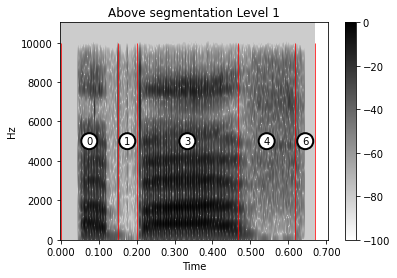

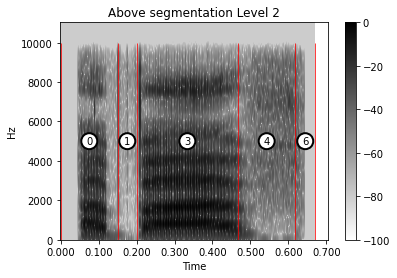

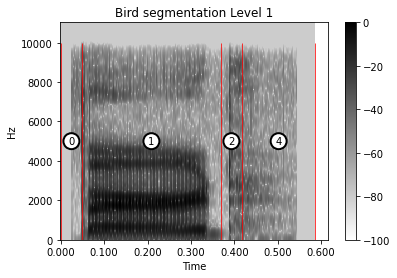

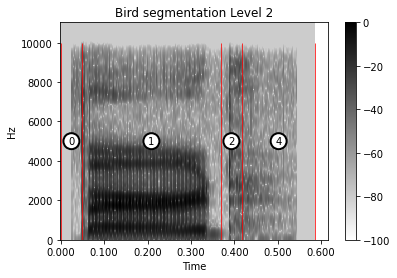

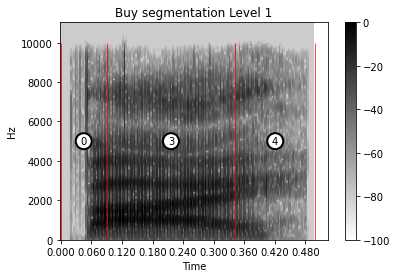

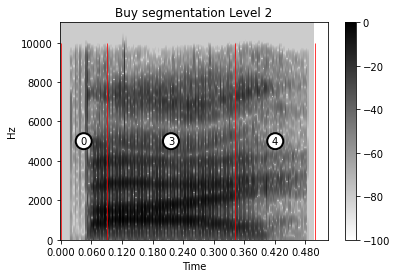

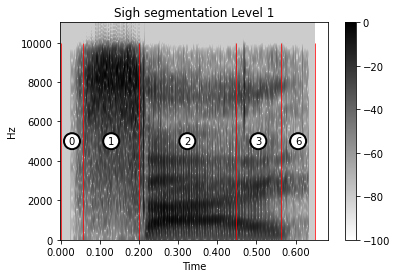

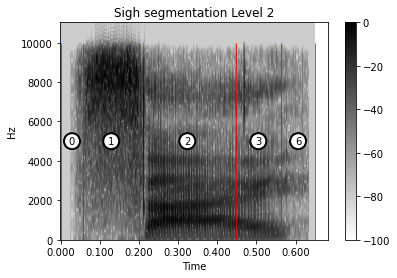

In [21]:
for word in ["Above","Bird","Buy","Sigh"]:
    word_frames = clip_dict[word]["frames"]

    word_data = next(item for item in data if item["fn"].split("/")[-1].split(".")[0].title() == word)

    #plot_segments_on_spectrogram(word_data["fourier"],refined_seg_dict[word],sr,title=f"{word} segmentation Level 1 refined",line_color='red')
    plot_segments_on_spectrogram(word_data["fourier"],pruned_seg_dict[word],sr,title=f"{word} segmentation Level 1",line_color='red')
    #plot_segments_on_spectrogram(word_data["fourier"],refined_seg_dict2[word],sr,title=f"{word} segmentation Level 2 refined",line_color='red')
    plot_segments_on_spectrogram(word_data["fourier"],pruned_seg_dict2[word],sr,title=f"{word} segmentation Level 2",line_color='red')